In [1]:
from google.colab import drive 
drive.mount('/content/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#model.py
import torch
import torch.nn as nn

from torchvision import models

class MRNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.alexnet(pretrained=True)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(256, 1)

    def forward(self, x):
        x = torch.squeeze(x, dim=0) # only batch size 1 supported
        x = self.model.features(x)
        x = self.gap(x).view(x.size(0), -1)
        x = torch.max(x, 0, keepdim=True)[0]
        x = self.classifier(x)
        return x

In [0]:
# loader.py

import numpy as np
import os
import pickle
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
import PIL

from torch.autograd import Variable

INPUT_DIM = 224
MAX_PIXEL_VAL = 255
MEAN = 58.09
STDDEV = 49.73

class Dataset(data.Dataset):
    def __init__(self, datadirs, diagnosis, use_gpu):
        super().__init__()
        self.use_gpu = use_gpu

        label_dict = {}
        self.paths = []

        for i, line in enumerate(open('metadata.csv').readlines()):
            if i == 0:
                continue
            line = line.strip().split(',')
            path = line[10]
            label = line[2]
            label_dict[path] = int(int(label) > diagnosis)

        for dir in datadirs:
            for file in os.listdir(dir):
                self.paths.append(dir+'/'+file)

        self.labels = [label_dict[path[6:]] for path in self.paths]

        neg_weight = np.mean(self.labels)
        self.weights = [neg_weight, 1 - neg_weight]

    def weighted_loss(self, prediction, target):
        weights_npy = np.array([self.weights[int(t[0])] for t in target.data])
        weights_tensor = torch.FloatTensor(weights_npy)
        if self.use_gpu:
            weights_tensor = weights_tensor.cuda()
        loss = F.binary_cross_entropy_with_logits(prediction, target, weight=Variable(weights_tensor))
        return loss

    def __getitem__(self, index):
        path = self.paths[index]
        with open(path, 'rb') as file_handler: # Must use 'rb' as the data is binary
            vol = pickle.load(file_handler).astype(np.int32)

        # crop middle
        pad = int((vol.shape[2] - INPUT_DIM)/2)
        vol = vol[:,pad:-pad,pad:-pad]
        
        # standardize
        vol = (vol - np.min(vol)) / (np.max(vol) - np.min(vol)) * MAX_PIXEL_VAL

        # normalize
        vol = (vol - MEAN) / STDDEV
        
        # convert to RGB
        vol = np.stack((vol,)*3, axis=1)

        vol_tensor = torch.FloatTensor(vol)
        label_tensor = torch.FloatTensor([self.labels[index]])

        return vol_tensor, label_tensor

    def __len__(self):
        return len(self.paths)

def load_data(diagnosis, use_gpu=False):
    train_dirs = ['vol08','vol04','vol03','vol09','vol06','vol07']
    valid_dirs = ['vol10','vol05']
    test_dirs = ['vol01','vol02']
    
    train_dataset = Dataset(train_dirs, diagnosis, use_gpu)
    valid_dataset = Dataset(valid_dirs, diagnosis, use_gpu)
    test_dataset = Dataset(test_dirs, diagnosis, use_gpu)

    train_loader = data.DataLoader(train_dataset, batch_size=1, num_workers=8, shuffle=True)
    valid_loader = data.DataLoader(valid_dataset, batch_size=1, num_workers=8, shuffle=False)
    test_loader = data.DataLoader(test_dataset, batch_size=1, num_workers=8, shuffle=False)

    return train_loader, valid_loader, test_loader



In [0]:
# evaluate.py

import argparse
import matplotlib.pyplot as plt
import os
import numpy as np
import torch

from sklearn import metrics
from torch.autograd import Variable

#from loader import load_data
#from model import MRNet

def get_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument('--model_path', type=str, required=True)
    parser.add_argument('--split', type=str, required=True)
    parser.add_argument('--diagnosis', type=int, required=True)
    parser.add_argument('--gpu', action='store_true')
    return parser

def run_model(model, loader, train=False, optimizer=None):
    preds = []
    labels = []

    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.
    num_batches = 0

    for batch in loader:
        if train:
            optimizer.zero_grad()

        vol, label = batch
        if loader.dataset.use_gpu:
            vol = vol.cuda()
            label = label.cuda()
        vol = Variable(vol)
        label = Variable(label)

        logit = model.forward(vol)

        loss = loader.dataset.weighted_loss(logit, label)
        total_loss += loss.item()

        pred = torch.sigmoid(logit)
        pred_npy = pred.data.cpu().numpy()[0][0]
        label_npy = label.data.cpu().numpy()[0][0]

        preds.append(pred_npy)
        labels.append(label_npy)

        if train:
            loss.backward()
            optimizer.step()
        num_batches += 1

    avg_loss = total_loss / num_batches

    fpr, tpr, threshold = metrics.roc_curve(labels, preds)
    auc = metrics.auc(fpr, tpr)

    return avg_loss, auc, preds, labels

def evaluate(split, model_path, diagnosis, use_gpu):
    train_loader, valid_loader, test_loader = load_data(diagnosis, use_gpu)

    model = MRNet()
    state_dict = torch.load(model_path, map_location=(None if use_gpu else 'cpu'))
    model.load_state_dict(state_dict)

    if use_gpu:
        model = model.cuda()

    if split == 'train':
        loader = train_loader
    elif split == 'valid':
        loader = valid_loader
    elif split == 'test':
        loader = test_loader
    else:
        raise ValueError("split must be 'train', 'valid', or 'test'")

    loss, auc, preds, labels = run_model(model, loader)

    print(f'{split} loss: {loss:0.4f}')
    print(f'{split} AUC: {auc:0.4f}')

    return preds, labels

#if __name__ == '__main__':
#    args = get_parser().parse_args()
#   evaluate(args.split, args.model_path, args.diagnosis, args.gpu)

In [0]:
# train.py

import argparse
import json
import numpy as np
import os
import torch

from datetime import datetime
from pathlib import Path
from sklearn import metrics

#from evaluate import run_model
#from loader import load_data
#from model import MRNet

def train(rundir, diagnosis, epochs, learning_rate, use_gpu):
    val_auc_array = list()
    train_auc_array = list()
    train_loader, valid_loader, test_loader = load_data(diagnosis, use_gpu)
    
    model = MRNet()
    
    if use_gpu:
        model = model.cuda()

    # modify the code in this
    optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=.3, threshold=1e-4)

    best_val_loss = float('inf')

    start_time = datetime.now()

    for epoch in range(epochs):
        change = datetime.now() - start_time
        print('starting epoch {}. time passed: {}'.format(epoch+1, str(change)))
        
        train_loss, train_auc, _, _ = run_model(model, train_loader, train=True, optimizer=optimizer)
        print(f'train loss: {train_loss:0.4f}')
        print(f'train AUC: {train_auc:0.4f}')

        val_loss, val_auc, _, _ = run_model(model, valid_loader)
        print(f'valid loss: {val_loss:0.4f}')
        print(f'valid AUC: {val_auc:0.4f}')
        val_auc_array.append(val_auc)
        train_auc_array.append(train_auc)
        
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss

            file_name = f'val{val_loss:0.4f}_train{train_loss:0.4f}_epoch{epoch+1}'
            save_path = Path(rundir) / file_name
            # dont need to save stuff for now, model is too shitty
            #torch.save(model.state_dict(), save_path)
            
    return val_auc_array, train_auc_array

def get_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument('--rundir', type=str, required=True)
    parser.add_argument('--diagnosis', type=int, required=True)
    parser.add_argument('--seed', default=42, type=int)
    parser.add_argument('--gpu', action='store_true')
    parser.add_argument('--learning_rate', default=1e-05, type=float)
    parser.add_argument('--weight_decay', default=0.01, type=float)
    parser.add_argument('--epochs', default=50, type=int)
    parser.add_argument('--max_patience', default=5, type=int)
    parser.add_argument('--factor', default=0.3, type=float)
    return parser

#if __name__ == '__main__':
#    args = get_parser().parse_args()
    
#    np.random.seed(args.seed)
#    torch.manual_seed(args.seed)
#    if args.gpu:
#        torch.cuda.manual_seed_all(args.seed)

#    os.makedirs(args.rundir, exist_ok=True)
    
#    with open(Path(args.rundir) / 'args.json', 'w') as out:
#        json.dump(vars(args), out, indent=4)

#    train(args.rundir, args.diagnosis, args.epochs, args.learning_rate, args.gpu)


In [6]:
import os
%cd "/content/gdrive/My Drive/thesis/Data/vols"

#data path
train_path = "/content/gdrive/My Drive/thesis/Data/train"
data_path = "/content/gdrive/My Drive/thesis/Data/vols"
#train_meniscus_csv_path = data_path + '/train-meniscus.csv'

gpu = True
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

#learningrate = 5e-05
epochs = 20
diagnosis = 0
rundir = data_path

if gpu:
  torch.cuda.manual_seed_all(seed)

def display_single(x_length, lr1, varray, tarray, title, xlabel, ylabel):
  plt.figure(0)
  plt.title(title)
  plt.plot(np.arange(x_length), varray, label='valid')
  plt.plot(np.arange(x_length), tarray, label='train')
  plt.legend()
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()
  return

def display_line(x_length, lr1, y1, lr2, y2, lr3, y3, lr4, y4, lr5, y5, title, xlabel, ylabel):
  plt.figure(0)
  # see if we can set axis later
  #ax = plt.axis()
  #ax.set(xlim = (np.min(x),np.max(x)), option='tight')
  plt.title(title)
  plt.plot(np.arange(x_length), y1, label=str(lr1))
  plt.plot(np.arange(x_length), y2, label=str(lr2))
  plt.plot(np.arange(x_length), y3, label=str(lr3))
  plt.plot(np.arange(x_length), y4, label=str(lr4))
  plt.plot(np.arange(x_length), y5, label=str(lr5))
  plt.legend()
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()
  return

/content/gdrive/My Drive/thesis/Data/vols


In [0]:
#sag w/o aug
epochs = 20
diagnosis = 0
lr = 1e-05
varray1, tarray1 = train(rundir, diagnosis, epochs, lr, gpu)
title = 'pretrained alexnet ' + str(diagnosis) + ' ' + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, title + 'w/o aug', 'epoch', 'AUC')

starting epoch 1. time passed: 0:00:00.000012
train loss: 0.2631
train AUC: 0.5220
valid loss: 0.2363
valid AUC: 0.6261
starting epoch 2. time passed: 0:02:06.219010
train loss: 0.2392
train AUC: 0.7214
valid loss: 0.2176
valid AUC: 0.7173
starting epoch 3. time passed: 0:03:59.640227
train loss: 0.2167
train AUC: 0.8229
valid loss: 0.2066
valid AUC: 0.7543
starting epoch 4. time passed: 0:05:45.746057
train loss: 0.1948
train AUC: 0.8631
valid loss: 0.1951
valid AUC: 0.7788
starting epoch 5. time passed: 0:07:24.882984
train loss: 0.1746
train AUC: 0.8921
valid loss: 0.1891
valid AUC: 0.8025
starting epoch 6. time passed: 0:08:58.924934
train loss: 0.1529
train AUC: 0.9341
valid loss: 0.1938
valid AUC: 0.8088
starting epoch 7. time passed: 0:10:29.498948
train loss: 0.1379
train AUC: 0.9393
valid loss: 0.1700
valid AUC: 0.8281
starting epoch 8. time passed: 0:11:56.642937
train loss: 0.1243
train AUC: 0.9571
valid loss: 0.1726
valid AUC: 0.8349
starting epoch 9. time passed: 0:13:20.4

TypeError: ignored

In [0]:
# loader.py

import numpy as np
import os
import pickle
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
import PIL

from torch.autograd import Variable

INPUT_DIM = 224
MAX_PIXEL_VAL = 255
MEAN = 58.09
STDDEV = 49.73

class Dataset(data.Dataset):
    def __init__(self, datadirs, diagnosis, use_gpu):
        super().__init__()
        self.use_gpu = use_gpu

        label_dict = {}
        self.paths = []

        for i, line in enumerate(open('metadata.csv').readlines()):
            if i == 0:
                continue
            line = line.strip().split(',')
            path = line[10]
            label = line[2]
            label_dict[path] = int(int(label) > diagnosis)

        for dir in datadirs:
            for file in os.listdir(dir):
                self.paths.append(dir+'/'+file)

        self.labels = [label_dict[path[6:]] for path in self.paths]

        neg_weight = np.mean(self.labels)
        self.weights = [neg_weight, 1 - neg_weight]

    def weighted_loss(self, prediction, target):
        weights_npy = np.array([self.weights[int(t[0])] for t in target.data])
        weights_tensor = torch.FloatTensor(weights_npy)
        if self.use_gpu:
            weights_tensor = weights_tensor.cuda()
        loss = F.binary_cross_entropy_with_logits(prediction, target, weight=Variable(weights_tensor))
        return loss

    def __getitem__(self, index):
        path = self.paths[index]
        with open(path, 'rb') as file_handler: # Must use 'rb' as the data is binary
            vol = pickle.load(file_handler).astype(np.int32)

        # crop middle
        pad = int((vol.shape[2] - INPUT_DIM)/2)
        vol = vol[:,pad:-pad,pad:-pad]

        vol = vol.astype(np.float32)
        transformbool = True

        flag = False
        randomangle = 0

        # define transform policy
        hor_flip = np.random.rand(1)
        ran_rot = np.random.rand(1) # change to 1
        randomangle = np.random.uniform(-25, 25)
                                        
        uni_noise = np.random.rand(1)

        """
        if ran_rot < 0.5:
          randomangle = 0
        """

        if transformbool:
          #if np.random.rand(1) < 0.5:
          flag = True

          if uni_noise < 0.5:
            noise_array = np.random.uniform(0.8,1.2,vol.shape[1]*vol.shape[2])
            noise_array.resize((1,vol.shape[1],vol.shape[2]))
            
            vol = np.multiply(vol, noise_array)
            vol = np.clip(vol, 0, 255)
            vol = vol.astype(np.float32)

          # flip, rotation, then shift
            #randomangle = np.random.uniform(-20,20)
          self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            #torchvision.transforms.Resize((224,224)),
            torchvision.transforms.RandomHorizontalFlip(p=(hor_flip < 0.5)), 
            torchvision.transforms.RandomRotation((randomangle,randomangle), resample=PIL.Image.BILINEAR),
            #torchvision.transforms.RandomCrop((224,224),pad_if_needed=True),
            torchvision.transforms.ToTensor()
        ])

        if flag:
          for sliceindex in range(vol.shape[0]):
            vol[sliceindex] = self.transforms(np.array(vol[sliceindex]))
        
        # standardize
        vol = (vol - np.min(vol)) / (np.max(vol) - np.min(vol)) * MAX_PIXEL_VAL

        # normalize
        vol = (vol - MEAN) / STDDEV
        
        # convert to RGB
        vol = np.stack((vol,)*3, axis=1)

        vol_tensor = torch.FloatTensor(vol)
        label_tensor = torch.FloatTensor([self.labels[index]])

        return vol_tensor, label_tensor

    def __len__(self):
        return len(self.paths)

def load_data(diagnosis, use_gpu=False):
    train_dirs = ['vol08','vol04','vol03','vol09','vol06','vol07']
    valid_dirs = ['vol10','vol05']
    test_dirs = ['vol01','vol02']
    
    train_dataset = Dataset(train_dirs, diagnosis, use_gpu)
    valid_dataset = Dataset(valid_dirs, diagnosis, use_gpu)
    test_dataset = Dataset(test_dirs, diagnosis, use_gpu)

    train_loader = data.DataLoader(train_dataset, batch_size=1, num_workers=8, shuffle=True)
    valid_loader = data.DataLoader(valid_dataset, batch_size=1, num_workers=8, shuffle=False)
    test_loader = data.DataLoader(test_dataset, batch_size=1, num_workers=8, shuffle=False)

    return train_loader, valid_loader, test_loader



In [0]:
#sag w/ aug
gpu = True
epochs = 20
diagnosis = 0
lr = 1e-05
varray1, tarray1 = train(rundir, diagnosis, epochs, lr, gpu)
title = 'pretrained alexnet ' + str(diagnosis) + ' ' + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, title + 'w/ aug', 'epoch', 'AUC')

starting epoch 1. time passed: 0:00:00.000011


KeyboardInterrupt: ignored

starting epoch 1. time passed: 0:00:00.000011
train loss: 0.2674
train AUC: 0.4745
valid loss: 0.2263
valid AUC: 0.5870
starting epoch 2. time passed: 0:01:38.069663
train loss: 0.2631
train AUC: 0.5171
valid loss: 0.2316
valid AUC: 0.5302
starting epoch 3. time passed: 0:03:09.676056
train loss: 0.2581
train AUC: 0.5688
valid loss: 0.2277
valid AUC: 0.6400
starting epoch 4. time passed: 0:04:41.408325
train loss: 0.2520
train AUC: 0.6303
valid loss: 0.2242
valid AUC: 0.6353
starting epoch 5. time passed: 0:06:13.879092
train loss: 0.2545
train AUC: 0.6025
valid loss: 0.2221
valid AUC: 0.6404
starting epoch 6. time passed: 0:07:45.515357
train loss: 0.2527
train AUC: 0.6327
valid loss: 0.2181
valid AUC: 0.7008
starting epoch 7. time passed: 0:09:14.364937
train loss: 0.2506
train AUC: 0.6344
valid loss: 0.2164
valid AUC: 0.7133
starting epoch 8. time passed: 0:10:43.676459
train loss: 0.2484
train AUC: 0.6465
valid loss: 0.2166
valid AUC: 0.6978
starting epoch 9. time passed: 0:12:12.6

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


train loss: 0.1728
train AUC: 0.8796
valid loss: 0.2001
valid AUC: 0.7413
starting epoch 39. time passed: 0:56:16.377313


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


train loss: 0.1750
train AUC: 0.8794
valid loss: 0.2033
valid AUC: 0.7311
starting epoch 40. time passed: 0:57:45.090122


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


train loss: 0.1698
train AUC: 0.8914


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


valid loss: 0.2039
valid AUC: 0.7405
starting epoch 41. time passed: 0:59:14.152022


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


train loss: 0.1687
train AUC: 0.8965


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


valid loss: 0.2017
valid AUC: 0.7389
starting epoch 42. time passed: 1:00:43.525776


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


train loss: 0.1729
train AUC: 0.8819
valid loss: 0.2075
valid AUC: 0.7192
starting epoch 43. time passed: 1:02:13.322472


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

train loss: 0.1696
train AUC: 0.8863
valid loss: 0.2024
valid AUC: 0.7367
starting epoch 44. time passed: 1:03:45.632341


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

train loss: 0.1715
train AUC: 0.8808


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

valid loss: 0.2038
valid AUC: 0.7304
starting epoch 45. time passed: 1:05:18.335343


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

train loss: 0.1671
train AUC: 0.8934


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


valid loss: 0.2018
valid AUC: 0.7379
starting epoch 46. time passed: 1:06:49.923807


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

train loss: 0.1745
train AUC: 0.8800


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


valid loss: 0.2011
valid AUC: 0.7400
starting epoch 47. time passed: 1:08:21.659067


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

train loss: 0.1673
train AUC: 0.8925


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

valid loss: 0.2006
valid AUC: 0.7418
starting epoch 48. time passed: 1:09:50.842416


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

train loss: 0.1708
train AUC: 0.8854


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

valid loss: 0.2001
valid AUC: 0.7444
starting epoch 49. time passed: 1:11:23.527738


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

train loss: 0.1722
train AUC: 0.8824


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

valid loss: 0.1998
valid AUC: 0.7453
starting epoch 50. time passed: 1:12:54.938081


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

train loss: 0.1690
train AUC: 0.8909


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

valid loss: 0.1999
valid AUC: 0.7442
starting epoch 51. time passed: 1:14:25.643250


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

train loss: 0.1696
train AUC: 0.8873


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

valid loss: 0.2004
valid AUC: 0.7422
starting epoch 52. time passed: 1:15:58.058968


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

train loss: 0.1638
train AUC: 0.8993


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


valid loss: 0.2006
valid AUC: 0.7414
starting epoch 53. time passed: 1:17:27.846210


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Traceback (most recent call last):
AssertionError: can only join a child process
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

train loss: 0.1665
train AUC: 0.8909


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

valid loss: 0.2006
valid AUC: 0.7425
starting epoch 54. time passed: 1:18:58.116198


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

train loss: 0.1663
train AUC: 0.8960


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

valid loss: 0.2007
valid AUC: 0.7424
starting epoch 55. time passed: 1:20:31.045901


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

train loss: 0.1711
train AUC: 0.8871


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


valid loss: 0.2004
valid AUC: 0.7435
starting epoch 56. time passed: 1:22:02.932873


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

train loss: 0.1611
train AUC: 0.9062


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


valid loss: 0.2006
valid AUC: 0.7427
starting epoch 57. time passed: 1:23:34.353820


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

train loss: 0.1718
train AUC: 0.8793


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

valid loss: 0.2006
valid AUC: 0.7422
starting epoch 58. time passed: 1:25:08.550783


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

train loss: 0.1658
train AUC: 0.8974


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

valid loss: 0.2006
valid AUC: 0.7420
starting epoch 59. time passed: 1:26:44.290809


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

train loss: 0.1710
train AUC: 0.8843


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

valid loss: 0.2005
valid AUC: 0.7422
starting epoch 60. time passed: 1:28:15.450555


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

train loss: 0.1630
train AUC: 0.9058


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
AssertionError: can only join a child process
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

valid loss: 0.2006
valid AUC: 0.7420
starting epoch 61. time passed: 1:29:44.963261


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

train loss: 0.1660
train AUC: 0.8998


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

valid loss: 0.2007
valid AUC: 0.7416
starting epoch 62. time passed: 1:31:13.021614


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

train loss: 0.1630
train AUC: 0.9056


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

valid loss: 0.2007
valid AUC: 0.7416
starting epoch 63. time passed: 1:32:41.672721


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

train loss: 0.1782
train AUC: 0.8626


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

valid loss: 0.2007
valid AUC: 0.7414
starting epoch 64. time passed: 1:34:10.052461


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

train loss: 0.1669
train AUC: 0.8953


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

valid loss: 0.2007
valid AUC: 0.7414
starting epoch 65. time passed: 1:35:38.133573


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

train loss: 0.1742
train AUC: 0.8748


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

valid loss: 0.2006
valid AUC: 0.7416
starting epoch 66. time passed: 1:37:06.465522


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    assert self._parent_pid == os.getpid(), 'can only join a child process'
    self._shutdown_workers()
AssertionError: can only join a child process
  File "/usr/local/l

train loss: 0.1661
train AUC: 0.8962


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


valid loss: 0.2006
valid AUC: 0.7416
starting epoch 67. time passed: 1:38:34.366498


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdf12d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

train loss: 0.1686
train AUC: 0.8950
valid loss: 0.2006
valid AUC: 0.7416
starting epoch 68. time passed: 1:40:00.997464
train loss: 0.1739
train AUC: 0.8800
valid loss: 0.2006
valid AUC: 0.7416
starting epoch 69. time passed: 1:41:28.066657
train loss: 0.1604
train AUC: 0.9125
valid loss: 0.2006
valid AUC: 0.7416
starting epoch 70. time passed: 1:42:54.282441
train loss: 0.1699
train AUC: 0.8911
valid loss: 0.2006
valid AUC: 0.7416
starting epoch 71. time passed: 1:44:20.581991
train loss: 0.1670
train AUC: 0.8954
valid loss: 0.2006
valid AUC: 0.7416
starting epoch 72. time passed: 1:45:47.749401
train loss: 0.1716
train AUC: 0.8840
valid loss: 0.2006
valid AUC: 0.7416
starting epoch 73. time passed: 1:47:15.491817
train loss: 0.1682
train AUC: 0.8914
valid loss: 0.2006
valid AUC: 0.7416
starting epoch 74. time passed: 1:48:44.449855
train loss: 0.1708
train AUC: 0.8868
valid loss: 0.2006
valid AUC: 0.7416
starting epoch 75. time passed: 1:50:13.604823
train loss: 0.1628
train AUC: 0.

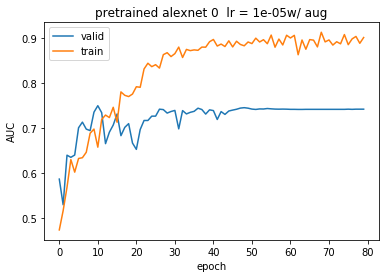

In [0]:
#sag w/ aug, made rotation happen always from -25,25, added noise layer
gpu = True
epochs = 80
diagnosis = 0
lr = 1e-05
varray1, tarray1 = train(rundir, diagnosis, epochs, lr, gpu)
title = 'pretrained alexnet ' + str(diagnosis) + ' ' + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, title + 'w/ aug', 'epoch', 'AUC')

In [0]:
# train.py

import argparse
import json
import numpy as np
import os
import torch

from datetime import datetime
from pathlib import Path
from sklearn import metrics

#from evaluate import run_model
#from loader import load_data
#from model import MRNet

def train(rundir, diagnosis, epochs, learning_rate, use_gpu):
    val_auc_array = list()
    train_auc_array = list()
    train_loader, valid_loader, test_loader = load_data(diagnosis, use_gpu)
    
    model = MRNet()
    
    if use_gpu:
        model = model.cuda()

    # modify the code in this
    optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1000, factor=.3, threshold=1e-4)

    best_val_loss = float('inf')

    start_time = datetime.now()

    for epoch in range(epochs):
        change = datetime.now() - start_time
        print('starting epoch {}. time passed: {}'.format(epoch+1, str(change)))
        
        train_loss, train_auc, _, _ = run_model(model, train_loader, train=True, optimizer=optimizer)
        print(f'train loss: {train_loss:0.4f}')
        print(f'train AUC: {train_auc:0.4f}')

        val_loss, val_auc, _, _ = run_model(model, valid_loader)
        print(f'valid loss: {val_loss:0.4f}')
        print(f'valid AUC: {val_auc:0.4f}')
        val_auc_array.append(val_auc)
        train_auc_array.append(train_auc)
        
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss

            file_name = f'val{val_loss:0.4f}_train{train_loss:0.4f}_epoch{epoch+1}'
            save_path = Path(rundir) / file_name
            # dont need to save stuff for now, model is too shitty
            #torch.save(model.state_dict(), save_path)
            
    return val_auc_array, train_auc_array

def get_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument('--rundir', type=str, required=True)
    parser.add_argument('--diagnosis', type=int, required=True)
    parser.add_argument('--seed', default=42, type=int)
    parser.add_argument('--gpu', action='store_true')
    parser.add_argument('--learning_rate', default=1e-05, type=float)
    parser.add_argument('--weight_decay', default=0.01, type=float)
    parser.add_argument('--epochs', default=50, type=int)
    parser.add_argument('--max_patience', default=5, type=int)
    parser.add_argument('--factor', default=0.3, type=float)
    return parser

#if __name__ == '__main__':
#    args = get_parser().parse_args()
    
#    np.random.seed(args.seed)
#    torch.manual_seed(args.seed)
#    if args.gpu:
#        torch.cuda.manual_seed_all(args.seed)

#    os.makedirs(args.rundir, exist_ok=True)
    
#    with open(Path(args.rundir) / 'args.json', 'w') as out:
#        json.dump(vars(args), out, indent=4)

#    train(args.rundir, args.diagnosis, args.epochs, args.learning_rate, args.gpu)


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:14<00:00, 16.9MB/s]


starting epoch 1. time passed: 0:00:00.000011
train loss: 0.2654
train AUC: 0.5258
valid loss: 0.2296
valid AUC: 0.5523
starting epoch 2. time passed: 0:02:17.136872
train loss: 0.2598
train AUC: 0.5539
valid loss: 0.2315
valid AUC: 0.5580
starting epoch 3. time passed: 0:04:35.747361
train loss: 0.2604
train AUC: 0.5390
valid loss: 0.2255
valid AUC: 0.6290
starting epoch 4. time passed: 0:06:40.079601
train loss: 0.2525
train AUC: 0.6203
valid loss: 0.2265
valid AUC: 0.6088
starting epoch 5. time passed: 0:08:30.509761
train loss: 0.2588
train AUC: 0.5688
valid loss: 0.2252
valid AUC: 0.5878
starting epoch 6. time passed: 0:10:10.831284
train loss: 0.2541
train AUC: 0.6115
valid loss: 0.2224
valid AUC: 0.6389
starting epoch 7. time passed: 0:11:45.372268
train loss: 0.2536
train AUC: 0.6116
valid loss: 0.2219
valid AUC: 0.6270
starting epoch 8. time passed: 0:13:16.428039
train loss: 0.2469
train AUC: 0.6580
valid loss: 0.2545
valid AUC: 0.6259
starting epoch 9. time passed: 0:14:45.7

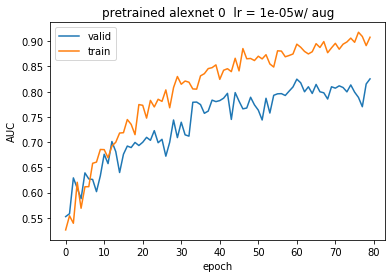

In [14]:
#sag w/ aug, made rotation happen always from -25,25, added noise layer
# changed patience value to 1000
gpu = True
epochs = 80
diagnosis = 0
lr = 1e-05
varray1, tarray1 = train(rundir, diagnosis, epochs, lr, gpu)
title = 'pretrained alexnet ' + str(diagnosis) + ' ' + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, title + 'w/ aug', 'epoch', 'AUC')

In [0]:
# train.py

import argparse
import json
import numpy as np
import os
import torch

from datetime import datetime
from pathlib import Path
from sklearn import metrics

#from evaluate import run_model
#from loader import load_data
#from model import MRNet

def train(rundir, diagnosis, epochs, learning_rate, use_gpu):
    val_auc_array = list()
    train_auc_array = list()
    train_loader, valid_loader, test_loader = load_data(diagnosis, use_gpu)
    
    model = MRNet()
    
    if use_gpu:
        model = model.cuda()

    # modify the code in this
    optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=.3, threshold=1e-4)

    best_val_loss = float('inf')

    start_time = datetime.now()

    for epoch in range(epochs):
        change = datetime.now() - start_time
        print('starting epoch {}. time passed: {}'.format(epoch+1, str(change)))
        
        train_loss, train_auc, _, _ = run_model(model, train_loader, train=True, optimizer=optimizer)
        print(f'train loss: {train_loss:0.4f}')
        print(f'train AUC: {train_auc:0.4f}')

        val_loss, val_auc, _, _ = run_model(model, valid_loader)
        print(f'valid loss: {val_loss:0.4f}')
        print(f'valid AUC: {val_auc:0.4f}')
        val_auc_array.append(val_auc)
        train_auc_array.append(train_auc)
        
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss

            file_name = f'val{val_loss:0.4f}_train{train_loss:0.4f}_epoch{epoch+1}'
            save_path = Path(rundir) / file_name
            # dont need to save stuff for now, model is too shitty
            #torch.save(model.state_dict(), save_path)
            
    return val_auc_array, train_auc_array

def get_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument('--rundir', type=str, required=True)
    parser.add_argument('--diagnosis', type=int, required=True)
    parser.add_argument('--seed', default=42, type=int)
    parser.add_argument('--gpu', action='store_true')
    parser.add_argument('--learning_rate', default=1e-05, type=float)
    parser.add_argument('--weight_decay', default=0.01, type=float)
    parser.add_argument('--epochs', default=50, type=int)
    parser.add_argument('--max_patience', default=5, type=int)
    parser.add_argument('--factor', default=0.3, type=float)
    return parser

#if __name__ == '__main__':
#    args = get_parser().parse_args()
    
#    np.random.seed(args.seed)
#    torch.manual_seed(args.seed)
#    if args.gpu:
#        torch.cuda.manual_seed_all(args.seed)

#    os.makedirs(args.rundir, exist_ok=True)
    
#    with open(Path(args.rundir) / 'args.json', 'w') as out:
#        json.dump(vars(args), out, indent=4)

#    train(args.rundir, args.diagnosis, args.epochs, args.learning_rate, args.gpu)


In [0]:
#model.py
import torch
import torch.nn as nn

from torchvision import models

class MRNet(nn.Module):
    def __init__(self):
        super().__init__()
        #self.model = models.alexnet(pretrained=True)
        self.model = models.densenet121(pretrained=True)
        self.gap = nn.AdaptiveAvgPool2d(1)
        #self.classifier = nn.Linear(256, 1)
        self.classifier = nn.Linear(1024,1)

    def forward(self, x):
        x = torch.squeeze(x, dim=0) # only batch size 1 supported
        x = self.model.features(x)
        x = self.gap(x).view(x.size(0), -1)
        x = torch.max(x, 0, keepdim=True)[0]
        x = self.classifier(x)
        return x

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 46.1MB/s]


starting epoch 1. time passed: 0:00:00.000012
train loss: 0.2722
train AUC: 0.5017
valid loss: 0.2544
valid AUC: 0.4649
starting epoch 2. time passed: 0:03:12.921468
train loss: 0.2597
train AUC: 0.5497
valid loss: 0.2560
valid AUC: 0.4737
starting epoch 3. time passed: 0:06:02.903871
train loss: 0.2582
train AUC: 0.5695
valid loss: 0.2505
valid AUC: 0.5057
starting epoch 4. time passed: 0:08:52.452687
train loss: 0.2535
train AUC: 0.6247
valid loss: 0.2435
valid AUC: 0.4971
starting epoch 5. time passed: 0:11:42.527227
train loss: 0.2493
train AUC: 0.6666
valid loss: 0.2459
valid AUC: 0.4829
starting epoch 6. time passed: 0:14:32.302397
train loss: 0.2503
train AUC: 0.6540
valid loss: 0.2500
valid AUC: 0.5118
starting epoch 7. time passed: 0:17:22.444466
train loss: 0.2453
train AUC: 0.6895
valid loss: 0.2542
valid AUC: 0.4976
starting epoch 8. time passed: 0:20:12.787123
train loss: 0.2372
train AUC: 0.7569
valid loss: 0.2446
valid AUC: 0.5052
starting epoch 9. time passed: 0:23:02.8

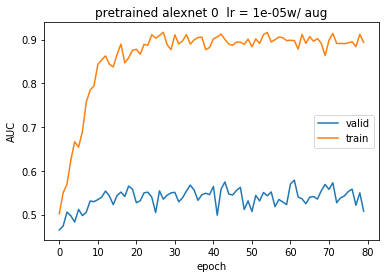

In [19]:
#sag w/ aug, made rotation happen always from -25,25, added noise layer
# densenet121
gpu = True
epochs = 80
diagnosis = 0
lr = 1e-05
varray1, tarray1 = train(rundir, diagnosis, epochs, lr, gpu)
title = 'pretrained alexnet ' + str(diagnosis) + ' ' + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, title + 'w/ aug', 'epoch', 'AUC')

In [0]:
#model.py
import torch
import torch.nn as nn

from torchvision import models

class MRNet(nn.Module):
    def __init__(self):
        super().__init__()
        #self.model = models.alexnet(pretrained=True)
        #self.model = models.densenet121(pretrained=True)
        self.model = models.vgg11_bn(pretrained=True)
        self.gap = nn.AdaptiveAvgPool2d(1)
        #self.classifier = nn.Linear(256, 1)
        self.classifier = nn.Linear(512,1)

    def forward(self, x):
        x = torch.squeeze(x, dim=0) # only batch size 1 supported
        x = self.model.features(x)
        x = self.gap(x).view(x.size(0), -1)
        x = torch.max(x, 0, keepdim=True)[0]
        x = self.classifier(x)
        return x

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:04<00:00, 115MB/s]


starting epoch 1. time passed: 0:00:00.000014
train loss: 0.2623
train AUC: 0.4555
valid loss: 0.2311
valid AUC: 0.4663
starting epoch 2. time passed: 0:03:23.150401
train loss: 0.2599
train AUC: 0.5575
valid loss: 0.2310
valid AUC: 0.4844
starting epoch 3. time passed: 0:05:44.192825
train loss: 0.2568
train AUC: 0.6288
valid loss: 0.2328
valid AUC: 0.4974
starting epoch 4. time passed: 0:07:51.905119
train loss: 0.2556
train AUC: 0.6032
valid loss: 0.2373
valid AUC: 0.4706
starting epoch 5. time passed: 0:09:54.032973
train loss: 0.2514
train AUC: 0.6555
valid loss: 0.2353
valid AUC: 0.4897
starting epoch 6. time passed: 0:11:55.230836
train loss: 0.2430
train AUC: 0.6977
valid loss: 0.2406
valid AUC: 0.4890
starting epoch 7. time passed: 0:13:56.649735
train loss: 0.2385
train AUC: 0.7148
valid loss: 0.2401
valid AUC: 0.5123
starting epoch 8. time passed: 0:15:56.996123
train loss: 0.2308
train AUC: 0.7435
valid loss: 0.2214
valid AUC: 0.6294
starting epoch 9. time passed: 0:17:57.5

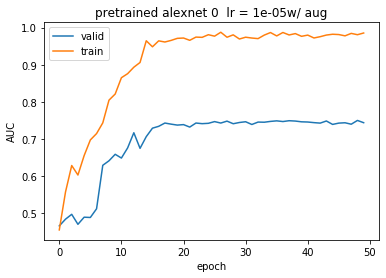

In [12]:
#sag w/ aug, made rotation happen always from -25,25, added noise layer
# vgg11_bn 
gpu = True
epochs = 50
diagnosis = 0
lr = 1e-05
varray1, tarray1 = train(rundir, diagnosis, epochs, lr, gpu)
title = 'pretrained alexnet ' + str(diagnosis) + ' ' + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, title + 'w/ aug', 'epoch', 'AUC')

In [0]:
#sag w/ aug, made rotation happen always from -25,25, added noise layer
# vgg11_bn
gpu = True
epochs = 50
diagnosis = 0
lr = 1e-04
varray1, tarray1 = train(rundir, diagnosis, epochs, lr, gpu)
title = 'pretrained vgg11_bn ' + str(diagnosis) + ' ' + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, title + 'w/ aug', 'epoch', 'AUC')

starting epoch 1. time passed: 0:00:00.000013
train loss: 0.2699
train AUC: 0.4910


In [0]:

#evaluate('test', 'val0.0175_train0.0139_epoch50', 1, True)

In [0]:

def display1_line(x_length, lr1, y1, lr2, y2, lr3, y3, lr4, y4, lr5, y5, title, xlabel, ylabel):
  plt.figure(0)
  # see if we can set axis later
  #ax = plt.axis()
  #ax.set(xlim = (np.min(x),np.max(x)), option='tight')
  plt.title(title)
  plt.plot(np.arange(x_length), y1, label=str(lr1))
  plt.plot(np.arange(x_length), y2, label=str(lr2))
  plt.plot(np.arange(x_length), y3, label=str(lr3))
  plt.plot(np.arange(x_length), y4, label=str(lr4))
  plt.plot(np.arange(x_length), y5, label=str(lr5))
  plt.legend()
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()
  return

display1_line(epochs, 5e-06, varray1, 1e-05, varray2, 5e-05, varray3, 1e-04, varray4, 1e-03, varray5, "AUC loss over epochs diagnosis = " + str(diagnosis), "epoch", "Validation AUC")

In [0]:
# notes from ben
# get rid of double standardization, dont have RGB channels all have same information, make AlexNet take 1 channel instead of 3. 
# try to dissect images into two camps, 3.0T and 1.5T.
# Then we can try to change into DenseNets. 